<a href="https://colab.research.google.com/github/zak-era12/Jovian-Assignments/blob/main/project_file2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1Tbo8veMylQGrv8CPCJSxpkVgNRgROsoa')

     |████████████████████████████████| 71kB 6.7MB/s 


## ***Street View House Numbers Detection ***

Our main goal is to detect and read house-number signs in Street View images. The entire end-toend system (described later) includes two main stages: 
 

1. a detection stage that locates individual house numbers in a large image, and
2. a recognition stage that performs a search over possible
character locations in the detected house number, classifying each candidate frame as one of ten
digits (0 through 9)



**About the Dataset** <br>
The SVHN dataset was obtained from a large number of Street View images using a combination
of automated algorithms and the Amazon Mechanical Turk (AMT) framework, which was used to localize and transcribe the single digits. We downloaded a very large set of images from
urban areas in various countries. From these randomly selected images, the house-number patches
were extracted using a dedicated sliding window house-numbers detector using a low threshold
on the detector’s confidence score in order to get a varied, unbiased dataset of house-number signs.
These low precision detections1 were screened and transcribed by AMT workers. In total, the dataset
comprises over 600,000 labeled characters, and has been made available in two formats:


*   Full Numbers - the original, variable-resolution, color house-number images as they appeared in the image file. Each image includes a transcription of the detected digits as well
as character level bounding boxes. Figure 2 shows the large variation in character height
as measured by the height of the bounding box of the characters in the original Street View
images.
*   Cropped Digits - character level ground truth - in this MNIST-like format all digits have
been resized to a fixed resolution of 32-by-32 pixels. The original character bounding boxes
are extended in the appropriate dimension to become square windows, so that resizing them
to 32-by-32 pixels does not introduce aspect ratio distortions.

The dataset is divided into three subsets-


*  SVHN train - 73,257 digits for training
* SVHN test - 26,032 digits for testing.
* SVHN extra (train) - 531,131 additional, somewhat less difficult samples, to use as extra
training data.
  

In [ ]:
project_name='project-house-numbers-detection2'

In [ ]:
import os 
import torch 
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image 
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn 
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
import tarfile
%matplotlib inline
import shutil


**Downloading the Dataset** <br>


In [ ]:
#Download the dataset
trainset_url="http://ufldl.stanford.edu/housenumbers/train.tar.gz"
download_url(trainset_url,'.')
testset_url="http://ufldl.stanford.edu/housenumbers/test.tar.gz"
download_url(testset_url, '.')

**Extracting and Exploring the Dataset**

In [ ]:
#Extract from archive
with tarfile.open('./train.tar.gz', 'r:gz') as tar:
  tar.extractall(path='./data')
with tarfile.open('./test.tar.gz', 'r:gz') as tar:
  tar.extractall(path='./data')

In [ ]:
data_dir='./data'
#shutil.rmtree(data_dir)
#print(os.listdir(data_dir))
train_classes=os.listdir(data_dir+"/train")
#print(train_classes)
#test_classes=os.listdir(data_dir+"/test")
#print(test_classes)
classes=os.listdir(data_dir)
print(classes)

['train', 'test']


In [ ]:
training_files=os.listdir(data_dir+'/train')
print("No. of training images: ", len(training_files))
testing_files=os.listdir(data_dir+'/test')
print("No. of testing images: ", len(testing_files))

No. of training images:  33404
No. of testing images:  13070


**Loading the data as Pytorch Tensors
**

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [ ]:
dataset = ImageFolder(data_dir, transform=ToTensor())

In [ ]:
# Lets look at the 10000th image in the form of a tensor
img, label = dataset[10000]
print(img.shape, label)
img

torch.Size([3, 33, 76]) 0


tensor([[[0.2039, 0.1922, 0.1922,  ..., 0.7255, 0.7255, 0.7255],
         [0.2118, 0.1922, 0.1922,  ..., 0.7255, 0.7255, 0.7255],
         [0.2078, 0.2000, 0.1961,  ..., 0.7255, 0.7255, 0.7255],
         ...,
         [0.0706, 0.0706, 0.0706,  ..., 0.7176, 0.7137, 0.7137],
         [0.0706, 0.0745, 0.0745,  ..., 0.7137, 0.7137, 0.7137],
         [0.0706, 0.0706, 0.0745,  ..., 0.6902, 0.6902, 0.6902]],

        [[0.2431, 0.2314, 0.2314,  ..., 0.6275, 0.6275, 0.6275],
         [0.2392, 0.2314, 0.2314,  ..., 0.6275, 0.6275, 0.6275],
         [0.2353, 0.2275, 0.2275,  ..., 0.6275, 0.6275, 0.6275],
         ...,
         [0.0706, 0.0706, 0.0706,  ..., 0.6157, 0.6196, 0.6196],
         [0.0706, 0.0745, 0.0745,  ..., 0.6196, 0.6196, 0.6196],
         [0.0667, 0.0745, 0.0745,  ..., 0.6235, 0.6235, 0.6235]],

        [[0.2078, 0.1961, 0.1882,  ..., 0.5059, 0.5059, 0.5059],
         [0.2078, 0.1961, 0.1882,  ..., 0.5059, 0.5059, 0.5059],
         [0.2039, 0.1961, 0.1843,  ..., 0.5059, 0.5059, 0.

In [ ]:
dataset.classes

['test', 'train']

In [ ]:
# Checking the size of the first 10 images in the dataset
im_count = 0
for image,_ in dataset:
  im_count += 1
  print(image.shape)
  if im_count == 10:
    break   

torch.Size([3, 47, 99])
torch.Size([3, 55, 87])
torch.Size([3, 133, 353])
torch.Size([3, 239, 625])
torch.Size([3, 42, 171])
torch.Size([3, 21, 47])
torch.Size([3, 52, 168])
torch.Size([3, 40, 107])
torch.Size([3, 38, 93])
torch.Size([3, 35, 64])


In [ ]:
#resizing the images
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.Resize((100, 500)), transforms.ToTensor()])

In [ ]:
dataset= ImageFolder(data_dir, transform = transform)

In [ ]:
# Checking the size of the first 10 images in the dataset
# after transforming
im_count = 0
for image,_ in dataset:
  im_count += 1
  print(image.shape)
  if im_count == 10:
    break   

torch.Size([3, 100, 500])
torch.Size([3, 100, 500])
torch.Size([3, 100, 500])
torch.Size([3, 100, 500])
torch.Size([3, 100, 500])
torch.Size([3, 100, 500])
torch.Size([3, 100, 500])
torch.Size([3, 100, 500])
torch.Size([3, 100, 500])
torch.Size([3, 100, 500])


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
# Helper Function to display the image
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    print('Image Shape: ', img.shape)
    plt.imshow(img.permute(1, 2, 0))

Label:  test (0)
Image Shape:  torch.Size([3, 100, 500])


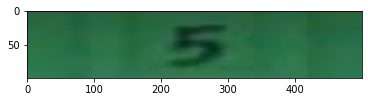

In [ ]:
show_example(*dataset[0])

Label:  test (0)
Image Shape:  torch.Size([3, 100, 500])


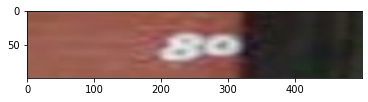

In [ ]:
show_example(*dataset[10])

Label:  test (0)
Image Shape:  torch.Size([3, 100, 500])


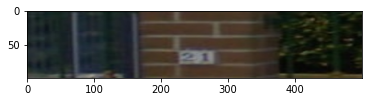

In [ ]:
show_example(*dataset[100])

Label:  test (0)
Image Shape:  torch.Size([3, 100, 500])


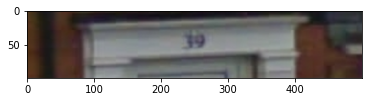

In [ ]:
show_example(*dataset[1000])

Label:  test (0)
Image Shape:  torch.Size([3, 100, 500])


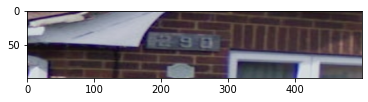

In [ ]:
show_example(*dataset[2000])

In [ ]:
#Saving Changes
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/zakera12m-hanif/project-house-numbers-detection2


'https://jovian.ai/zakera12m-hanif/project-house-numbers-detection2'

In [ ]:
random_seed = 44
torch.manual_seed(random_seed);

In [ ]:
val_size = 13000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(33470, 13000)

In [ ]:
#logging the dataset
jovian.log_dataset(trainset_url=trainset_url, val_size=val_size, random_seed=random_seed)

[jovian] Dataset logged.


**Creating data loaders to load data in batches for training and validation**

In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size=32
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
from torchvision.utils import make_grid
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(50, 20))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

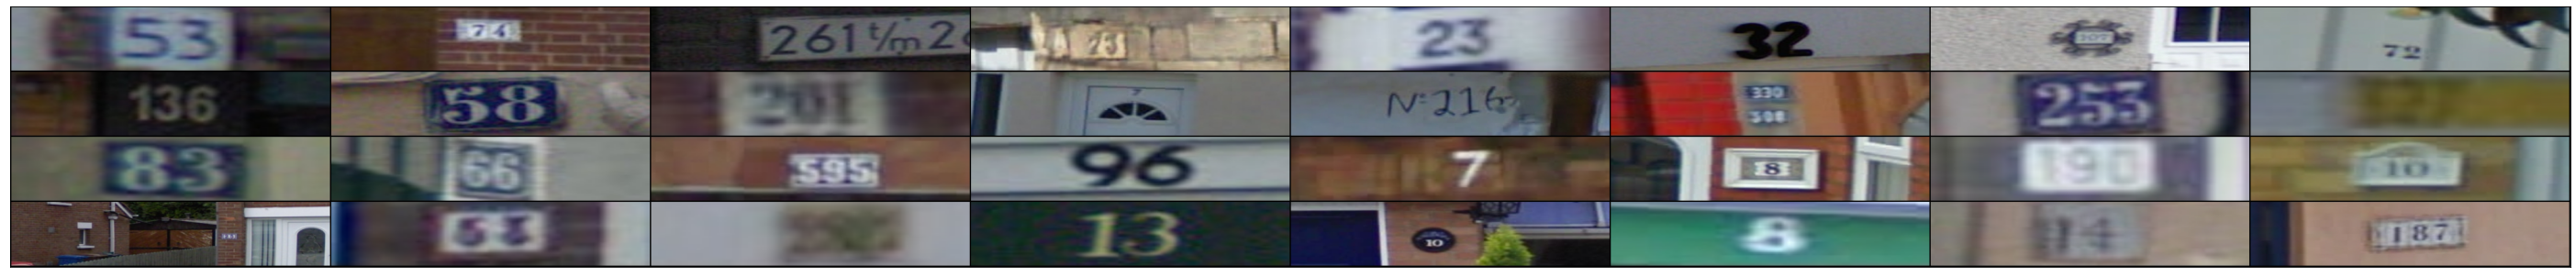

In [ ]:
show_batch(train_dl)

**Defining the Model**

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class HouseNumberModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(100, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(200, 400, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(400, 400, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(400, 800, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(800, 800, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(800*4*4, 3200),
            nn.ReLU(),
            nn.Linear(3200, 1600),
            nn.ReLU(),
            nn.Linear(1600, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model=HouseNumberModel()
model

HouseNumberModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(200, 400, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(400, 400, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(400, 800, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(800, 800, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=12800, out_features=3200, bias=True)
    (17): ReLU()
    (18): Linear(i

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [ ]:
#Training the model
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    for e in range(epochs):
      for images, labels in train_loader:   
        if torch.cuda.is_available():
          images, labels = images.cuda(), labels.cuda()
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
'''torch.cuda.empty_cache()
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break'''
'''for e in range(epochs):
  for images, labels in train_loader:   
    if torch.cuda.is_available():
      images, labels = images.cuda(), labels.cuda() '''

'for e in range(epochs):\n  for images, labels in train_loader:   \n    if torch.cuda.is_available():\n      images, labels = images.cuda(), labels.cuda() '

In [ ]:
model = to_device(HouseNumberModel(), device)

In [ ]:
evaluate(model, val_dl)

RuntimeError: ignored

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [ ]:
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])

In [ ]:
jovian.commit(project=project_name)